In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%config InlineBackend.figure_format = "retina"
plt.rcParams["font.family"]="STSong"
plt.rcParams['axes.unicode_minus']=False  

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.inspection import permutation_importance

import shap

In [2]:
data = pd.read_csv(os.getcwd()+'\\data\\ABOX_raw_features_eb.csv')
print(data.shape)
data.head()

(1341, 73)


,material_id,pretty_formula,full_formula,unit_cell_formula,density,spacegroup.crystal_system,volume,band_gap,formation_energy_per_atom,e_above_hull,...,gamma,nA,nB,nX,rA,rB,rX,mu,t,tau
0,mp-10250,BaLiF3,Ba1Li1F3,"{'Ba': 1.0, 'Li': 1.0, 'F': 3.0}",5.020980,0,66.561793,6.5716,-3.767297,0.014824,...,90.000000,2.0,1.0,-1.0,1.61,0.76,1.33,0.571429,0.994686,3.394073
1,mp-1097061,CaTlF3,Ca1Tl1F3,"{'Ca': 1.0, 'Tl': 1.0, 'F': 3.0}",5.456459,2,91.740879,4.8393,-3.321972,0.018100,...,89.962853,1.0,2.0,-1.0,1.70,1.00,1.33,0.751880,0.919542,3.533750
2,mp-998150,CaTlF3,Ca1Tl1F3,"{'Ca': 1.0, 'Tl': 1.0, 'F': 3.0}",5.446106,3,91.915271,4.8398,-3.321913,0.018159,...,90.090621,1.0,2.0,-1.0,1.70,1.00,1.33,0.751880,0.919542,3.533750
3,mp-12262,CsBeF3,Cs4Be4F12,"{'Cs': 4.0, 'Be': 4.0, 'F': 12.0}",3.397007,3,388.933579,6.6615,-3.425382,0.000000,...,90.000000,1.0,2.0,-1.0,1.88,0.45,1.33,0.338346,1.275176,4.877529
4,mp-1017555,CsBeF3,Cs1Be1F3,"{'Cs': 1.0, 'Be': 1.0, 'F': 3.0}",5.026564,0,65.711400,5.3850,-2.762829,0.662552,...,90.000000,1.0,2.0,-1.0,1.88,0.45,1.33,0.338346,1.275176,4.877529


In [3]:
# Check data for missing values
num = data.isnull().sum()
miss = data.isnull()
print(data.isnull().sum().sum()) 
print(data[data.isnull().any(axis=1)].shape)

0
(0, 73)


In [4]:
colNameDict = {'formation_energy_per_atom':'Ef',
               'e_above_hull':'Ehull', 
               'spacegroup.crystal_system':'cry_sys'}
data.rename(columns=colNameDict, inplace=True)

In [5]:
data.columns

Index(['material_id', 'pretty_formula', 'full_formula', 'unit_cell_formula',
       'density', 'cry_sys', 'volume', 'band_gap', 'Ef', 'Ehull', 'z_A', 'z_B',
       'z_X', 'row_A', 'row_B', 'row_X', 'grp_A', 'grp_B', 'grp_X',
       'atom_mass_A', 'atom_mass_B', 'atom_mass_X', 'mol_vol_A', 'mol_vol_B',
       'mol_vol_X', 'ion_rad_A', 'ion_rad_B', 'ion_rad_X', 'cov_rad_A',
       'cov_rad_B', 'cov_rad_X', 'vdw_rad_A', 'vdw_rad_B', 'vdw_rad_X', 'x_A',
       'x_B', 'x_X', 'ea_A', 'ea_B', 'ea_X', 'k_A', 'k_B', 'k_X', 'val_A',
       'val_B', 'val_X', 'bp_A', 'bp_B', 'bp_X', 'mp_A', 'mp_B', 'mp_X',
       'heat_fus_A', 'heat_fus_B', 'heat_fus_X', 'ie_A', 'ie_B', 'ie_X', 'a',
       'b', 'c', 'alpha', 'beta', 'gamma', 'nA', 'nB', 'nX', 'rA', 'rB', 'rX',
       'mu', 't', 'tau'],
      dtype='object')

In [6]:
data_1 = data.drop(['material_id', 'pretty_formula', 'full_formula',
                    'unit_cell_formula'], axis=1)

In [7]:
print(data_1.shape)
data_1.columns

(1341, 69)


Index(['density', 'cry_sys', 'volume', 'band_gap', 'Ef', 'Ehull', 'z_A', 'z_B',
       'z_X', 'row_A', 'row_B', 'row_X', 'grp_A', 'grp_B', 'grp_X',
       'atom_mass_A', 'atom_mass_B', 'atom_mass_X', 'mol_vol_A', 'mol_vol_B',
       'mol_vol_X', 'ion_rad_A', 'ion_rad_B', 'ion_rad_X', 'cov_rad_A',
       'cov_rad_B', 'cov_rad_X', 'vdw_rad_A', 'vdw_rad_B', 'vdw_rad_X', 'x_A',
       'x_B', 'x_X', 'ea_A', 'ea_B', 'ea_X', 'k_A', 'k_B', 'k_X', 'val_A',
       'val_B', 'val_X', 'bp_A', 'bp_B', 'bp_X', 'mp_A', 'mp_B', 'mp_X',
       'heat_fus_A', 'heat_fus_B', 'heat_fus_X', 'ie_A', 'ie_B', 'ie_X', 'a',
       'b', 'c', 'alpha', 'beta', 'gamma', 'nA', 'nB', 'nX', 'rA', 'rB', 'rX',
       'mu', 't', 'tau'],
      dtype='object')

### 1、Using original features

In [8]:
X = data_1.drop(['band_gap', 'Ef', 'Ehull'], axis=1)
print(type(X), X.shape)

y = data_1[['Ef']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3
)
print("training set：",len(X_train)," test set：",  len(X_test))

<class 'pandas.core.frame.DataFrame'> (1341, 66)
training set： 1072  test set： 269


In [9]:
# default parameters
tuned_params_gbr = {
    "random_state": [3]
}

In [10]:
# Converts the list of elements in the tuned_params_gbr dictionary to a single value
params = {}
for k,v in tuned_params_gbr.items():
    params[k] = v[0]
gbr = ensemble.GradientBoostingRegressor(**params)

In [11]:
model = gbr.fit(X_train, y_train)

In [12]:
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
    
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.9611838735743355 
RMSE: 0.1539899326732339 
MAE: 0.10873655317993597


In [13]:
df_result = pd.DataFrame({"test":y_test,
                          "pred":GBR_test_pred})
df_result.to_csv(os.getcwd()+"\\result\\data\\Ef_without_raw.csv", index=False)

In [14]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np

config = {
    "font.family":'serif',
    "font.size": 18,
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

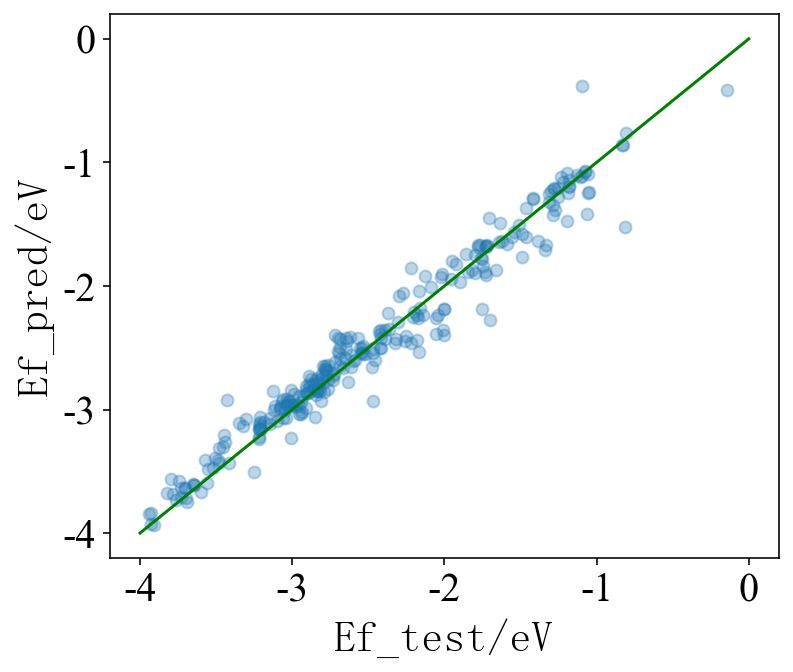

In [15]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(y_test, GBR_test_pred, alpha=0.3)
ax.set_xlabel('Ef_test/eV', fontsize=22)
ax.set_ylabel('Ef_pred/eV', fontsize=22)
# ax.set_xlim(-4, 0)
# ax.set_ylim(-4, 0)
ax.plot([-4, 0], [-4, 0], color='green')
plt.xticks(fontproperties='Times New Roman', size=20)
plt.yticks(fontproperties='Times New Roman', size=20)
plt.show()

In [16]:
from sklearn.model_selection import cross_val_score

In [17]:
scores = cross_val_score(gbr, X_train, y_train, cv=5)

In [18]:
print(scores)
print(scores.mean())

[0.94330658 0.93575389 0.94635639 0.94747963 0.97085454]
0.9487502076515859


### GBR parameters optimization
1.default parameter

In [81]:
GBR = ensemble.GradientBoostingRegressor()
grid_gbr = GridSearchCV(estimator=GBR, param_grid=tuned_params_gbr, 
                           cv=5, scoring='r2', n_jobs=4, verbose=2, 
                           return_train_score=True)

grid_gbr.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'random_state': [3]}, return_train_score=True,
             scoring='r2', verbose=2)

In [82]:
# Get the result parameter of GridSearchCV
best_params = grid_gbr.best_params_
best_score = grid_gbr.best_score_
cv_results = grid_gbr.cv_results_

In [83]:
print(best_score)

0.9487502076515859


In [84]:
# 在测试数据上的结果 
GBR_test_pred = grid_gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
MSE = mean_squared_error(y_test, GBR_test_pred)
MAE = mean_absolute_error(y_test, GBR_test_pred)
print('r^2:', r2, '\nMSE:', MSE, '\nMAE:', MAE)

r^2: 0.9611838735743355 
MSE: 0.02371289936470711 
MAE: 0.10873655317993597


In [85]:
tuned_params_gbr

{'random_state': [3]}

2、parameters tuning

(1) n_estimators & learning_rate

In [86]:
tuned_params_gbr["n_estimators"] = range(500, 1500, 100)
tuned_params_gbr["learning_rate"] = np.linspace(0.05, 0.15, 11)

In [87]:
GBR = ensemble.GradientBoostingRegressor()
grid_gbr = GridSearchCV(estimator=GBR, param_grid=tuned_params_gbr, 
                           cv=5, scoring='r2', n_jobs=4, verbose=3,
                           return_train_score=True)

grid_gbr.fit(X_train, y_train)

# 获得GridSearchCV的结果参数
best_params = grid_gbr.best_params_
best_score = grid_gbr.best_score_
cv_results = grid_gbr.cv_results_

Fitting 5 folds for each of 110 candidates, totalling 550 fits


In [88]:
print(best_score)

0.9627325191693951


In [89]:
# result
GBR_test_pred = grid_gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.9755009148869068 
RMSE: 0.12233794061583265 
MAE: 0.07623200644007348


In [92]:
def plot_heatmap(params, best_params, best_score, score_data, 
                 x_label, y_label, fig_size=(20, 10)):
    """
    params: tuned_params 
    score_data: cv_results 
    """
    scores = np.reshape(score_data["mean_test_score"], 
                       (len(params[x_label]), len(params[y_label])))

    fig, ax = plt.subplots(figsize=fig_size)
    ax = sns.heatmap(scores.T, square=True, annot=True, fmt = ".4f",
                     yticklabels=params[y_label], 
                     xticklabels=['{:.2f}'.format(i) for i in params[x_label]], 
                     linewidths=.5, cmap="YlGnBu",
                     cbar_kws={"fraction":0.046, "pad":0.03})
    
    ax.set_title(f"mean_test_score with best params : ( {y_label} = {best_params[y_label]},{x_label} = {best_params[x_label]} )"
                 +f" and score : {best_score:.4f}" )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    plt.show()  

In [95]:
plt.rcParams["font.family"]="SimHei"

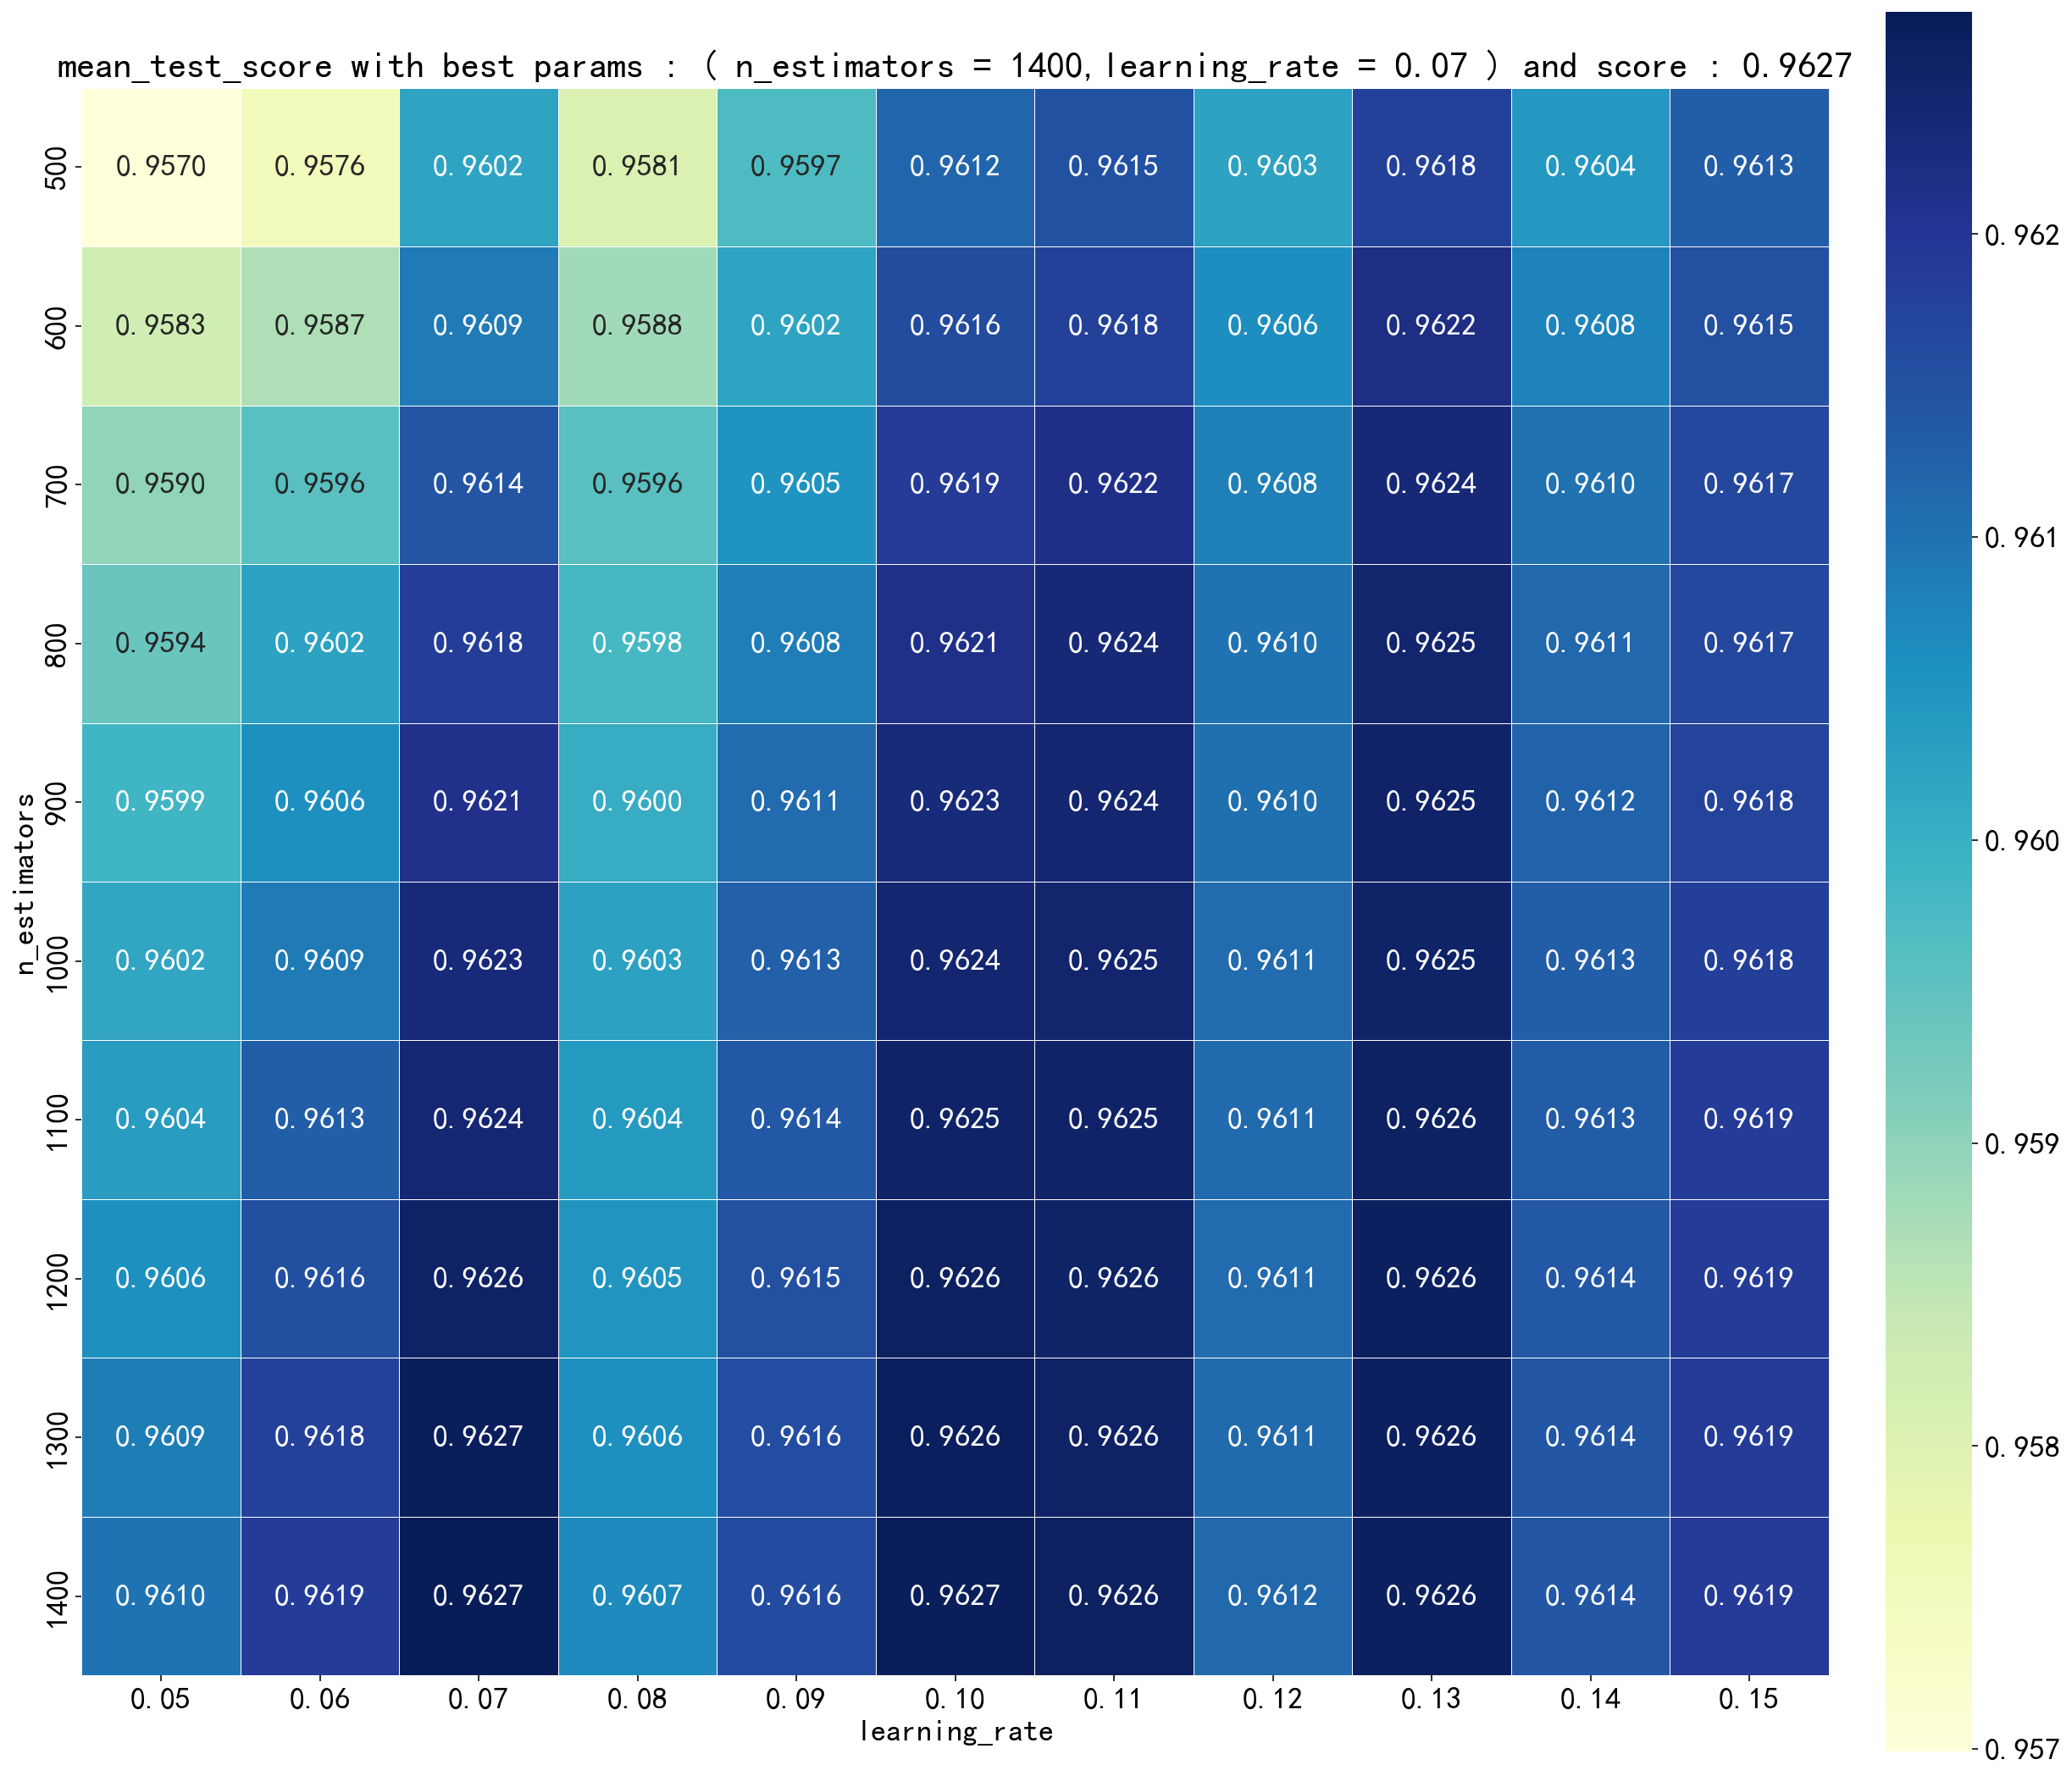

In [96]:
plot_heatmap(tuned_params_gbr, best_params, best_score, cv_results, 
             x_label="learning_rate", y_label="n_estimators", 
             fig_size=(20, 20))

(2)  max_depth

In [98]:
tuned_params_gbr["n_estimators"] = [best_params["n_estimators"]]
tuned_params_gbr["learning_rate"] = [best_params["learning_rate"]]
tuned_params_gbr["max_depth"] = [2, 3, 4, 5, 6, 7]  

In [99]:
GBR = ensemble.GradientBoostingRegressor()
grid_gbr = GridSearchCV(estimator=GBR, param_grid=tuned_params_gbr, 
                           cv=5, scoring='r2', n_jobs=4, 
                           return_train_score=True)

grid_gbr.fit(X_train, y_train)

best_params = grid_gbr.best_params_
best_score = grid_gbr.best_score_
cv_results = grid_gbr.cv_results_

In [100]:
print(best_params,'\nbest_score:', best_score)

{'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 1400, 'random_state': 3} 
best_score: 0.9627325191693951


In [101]:
GBR_test_pred = grid_gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.9755009148869068 
RMSE: 0.12233794061583265 
MAE: 0.07623200644007348


In [102]:
import matplotlib.ticker as mtick
def plot_line(x_data, y_data, x_label, best_params, cat):
    fig = plt.figure()
    ax = fig.add_subplot()
    y = y_data['mean_test_score']
    ax.plot(x_data[x_label], y, 'b-.o')
    
    ax.set_xlabel(x_label)
    ax.set_ylabel('mean_test_score')
    ax.set_title(f"best {x_label} : {best_params[x_label]} " 
                 + f"with best score : {max(y):.5f}")
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.4f'))
 
    plt.show()

In [104]:
config = {
    "font.family":'serif',
    "font.size": 10,
    "mathtext.fontset":'stix',
    "font.serif": ['SimHei'],
}
rcParams.update(config)

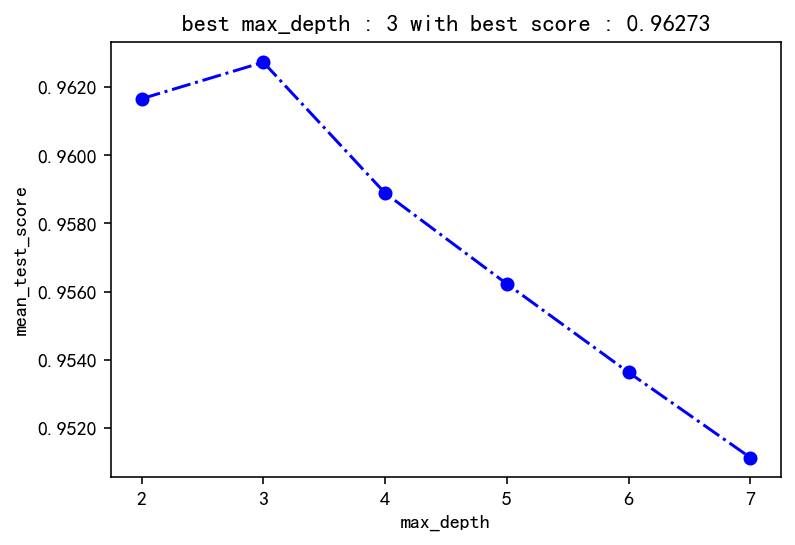

In [105]:
plot_line(tuned_params_gbr, cv_results,
          x_label = "max_depth",
          best_params = best_params, 
          cat="Ef_without")

(3)  min_sample_split & min_sample_leaf

In [106]:
tuned_params_gbr["max_depth"] = [best_params["max_depth"]]  
tuned_params_gbr["min_samples_split"] = [2, 3, 4, 5, 7, 8, 9, 10]

In [107]:
GBR = ensemble.GradientBoostingRegressor()
grid_gbr = GridSearchCV(estimator=GBR, param_grid=tuned_params_gbr, 
                           cv=5, scoring='r2', n_jobs=4, 
                           return_train_score=True)

grid_gbr.fit(X_train, y_train)

best_params = grid_gbr.best_params_
best_score = grid_gbr.best_score_
cv_results = grid_gbr.cv_results_

In [108]:
print(best_params,'\nbest_score: ', best_score) 
GBR_test_pred = grid_gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

{'learning_rate': 0.07, 'max_depth': 3, 'min_samples_split': 8, 'n_estimators': 1400, 'random_state': 3} 
best_score:  0.9633376102798357
r^2: 0.9746928453600079 
RMSE: 0.1243391492941784 
MAE: 0.0765809887275928


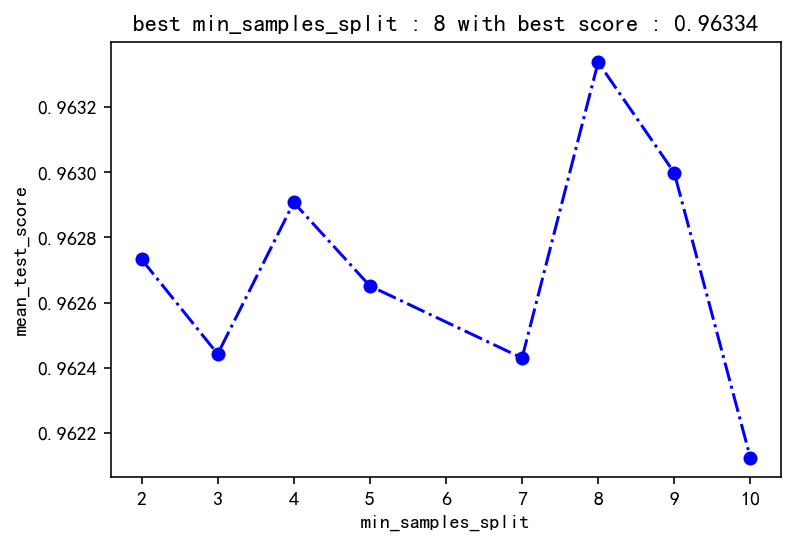

In [109]:
plot_line(tuned_params_gbr, cv_results,
          x_label = "min_samples_split",
          best_params = best_params, 
          cat="Ef_without")

In [110]:
tuned_params_gbr["min_samples_split"] = [best_params["min_samples_split"]] # 将要调整的参数
tuned_params_gbr["min_samples_leaf"] = [1, 2, 3, 4, 5, 6, 7, 8]

In [111]:
GBR = ensemble.GradientBoostingRegressor()
grid_gbr = GridSearchCV(estimator=GBR, param_grid=tuned_params_gbr, 
                           cv=5, scoring='r2', n_jobs=4, 
                           return_train_score=True)

grid_gbr.fit(X_train, y_train)

best_params = grid_gbr.best_params_
best_score = grid_gbr.best_score_
cv_results = grid_gbr.cv_results_

In [112]:
print(best_params, best_score)
GBR_test_pred = grid_gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

{'learning_rate': 0.07, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1400, 'random_state': 3} 0.9633376102798357
r^2: 0.9746928453600079 
RMSE: 0.1243391492941784 
MAE: 0.0765809887275928


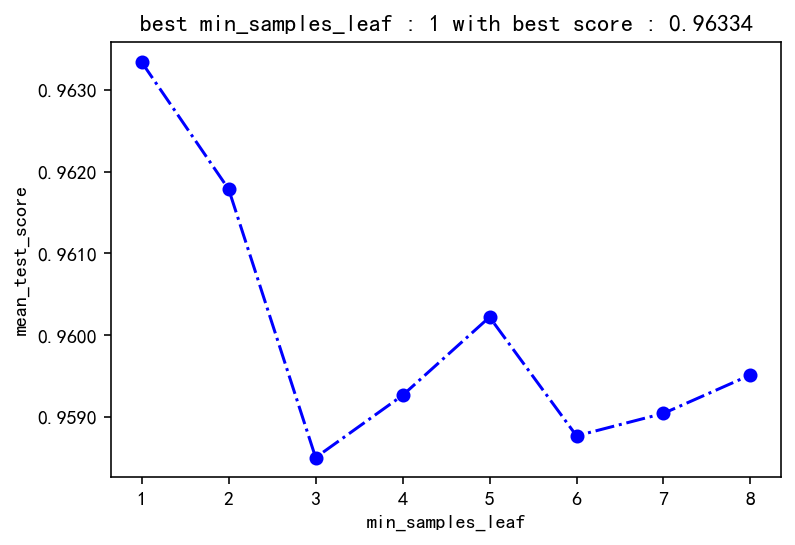

In [113]:
plot_line(tuned_params_gbr, cv_results,
          x_label = "min_samples_leaf",
          best_params = best_params, 
          cat="Ef_without")

(4) max_features

In [169]:
tuned_params_gbr["min_samples_leaf"] = [best_params["min_samples_leaf"]]
tuned_params_gbr["max_features"] = np.arange(5, 15, 1)

In [170]:
GBR = ensemble.GradientBoostingRegressor()
grid_gbr = GridSearchCV(estimator=GBR, param_grid=tuned_params_gbr, 
                           cv=5, scoring='r2', n_jobs=4, 
                           return_train_score=True)

grid_gbr.fit(X_train, y_train)
best_params = grid_gbr.best_params_
best_score = grid_gbr.best_score_
cv_results = grid_gbr.cv_results_

In [171]:
print(best_params, best_score) 
GBR_test_pred = grid_gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

{'learning_rate': 0.07, 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 1400, 'random_state': 3} 0.9677104165998163
r^2: 0.9798062759784886 
RMSE: 0.11106940377858461 
MAE: 0.07242167719795897


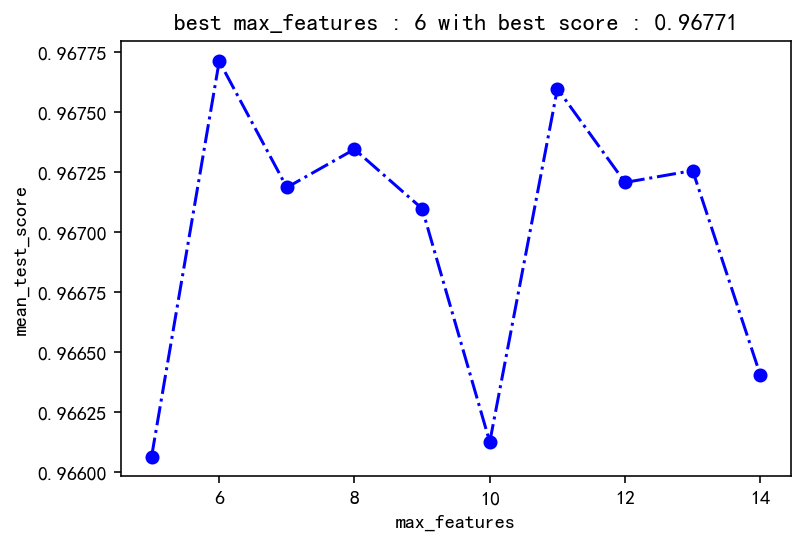

In [172]:
plot_line(tuned_params_gbr, cv_results,
          x_label = "max_features",
          best_params = best_params, 
          cat="Ef_without")

In [173]:
tuned_params_gbr["max_features"] = [best_params["max_features"]]
tuned_params_gbr

{'random_state': [3],
 'n_estimators': [1400],
 'learning_rate': [0.07],
 'max_depth': [3],
 'min_samples_split': [8],
 'min_samples_leaf': [1],
 'max_features': [6]}

In [20]:
tuned_params_gbr = {'random_state': [3],
                    'n_estimators': [1400],
                    'learning_rate': [0.07],
                    'max_depth': [3],
                    'min_samples_split': [8],
                    'min_samples_leaf': [1],
                    'max_features': [6]}

tuned_params_gbr

{'random_state': [3],
 'n_estimators': [1400],
 'learning_rate': [0.07],
 'max_depth': [3],
 'min_samples_split': [8],
 'min_samples_leaf': [1],
 'max_features': [6]}

### band_gap prediction
1.default parameters

In [19]:
X = data_1.drop(['band_gap', 'Ef', 'Ehull'], axis=1)
print(type(X), X.shape)

y = data_1[['band_gap']].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3
)
print("training set：",len(X_train)," test set：",  len(X_test))

<class 'pandas.core.frame.DataFrame'> (1341, 66)
training set： 1072  test set： 269


In [20]:
tuned_params_gbr = {
    "random_state": [3]
}

In [21]:
params = {}
for k,v in tuned_params_gbr.items():
    params[k] = v[0]
gbr = ensemble.GradientBoostingRegressor(**params)

In [22]:
model = gbr.fit(X_train, y_train)

In [23]:
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)
    
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.7355420273475634 
RMSE: 0.7772369072597296 
MAE: 0.5930229549989758


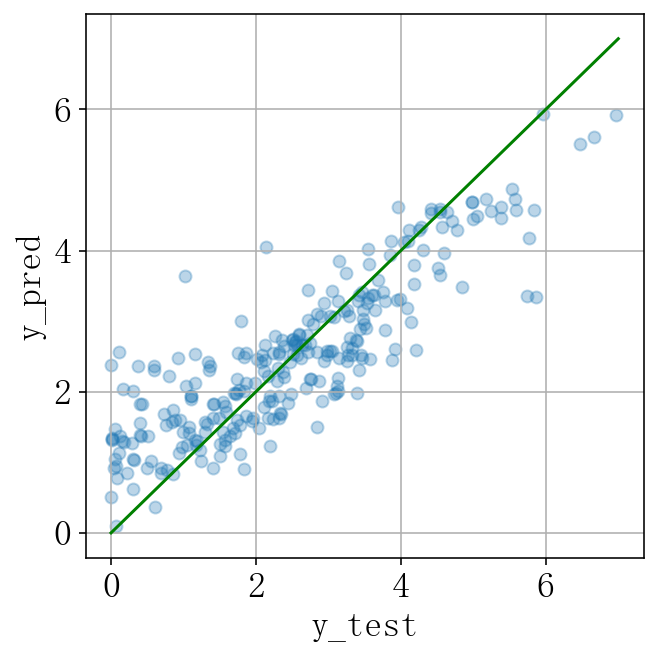

In [24]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(y_test, GBR_test_pred, alpha=0.3)
ax.grid()
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')
# ax.set_xlim(-4, 0)
# ax.set_ylim(-4, 0)
ax.plot([0, 7], [0, 7], color='green')
plt.show()

In [25]:
from sklearn.model_selection import cross_val_score

In [26]:
scores = cross_val_score(gbr, X_train, y_train, cv=5)

In [27]:
print(scores)
print(scores.mean())

[0.63134308 0.6374936  0.69281965 0.65144826 0.7435589 ]
0.6713326974937999


2.optimized parameters

In [28]:
tuned_params_gbr = {'random_state': [3],
                    'max_features': [8],
                    'n_estimators': [1300],
                    'learning_rate': [0.04],
                    'max_depth': [4],
                    'min_samples_split': [2],
                    'min_samples_leaf': [1]}

tuned_params_gbr

{'random_state': [3],
 'max_features': [8],
 'n_estimators': [1300],
 'learning_rate': [0.04],
 'max_depth': [4],
 'min_samples_split': [2],
 'min_samples_leaf': [1]}

In [29]:
params = {}
for k,v in tuned_params_gbr.items():
    params[k] = v[0]
gbr = ensemble.GradientBoostingRegressor(**params)

In [30]:
model = gbr.fit(X_train, y_train)

In [31]:
GBR_test_pred = gbr.predict(X_test)
r2 = r2_score(y_test, GBR_test_pred)
RMSE = mean_squared_error(y_test, GBR_test_pred)**0.5
MAE = mean_absolute_error(y_test, GBR_test_pred)

least_feature_list = ["first"] 
r2_list = [r2]         
RMSE_list = [RMSE]
MAE_list = [MAE]
    
print('r^2:', r2, '\nRMSE:', RMSE, '\nMAE:', MAE)

r^2: 0.8247227377519329 
RMSE: 0.63275833324126 
MAE: 0.4555257044115285


In [32]:
scores = cross_val_score(gbr, X_train, y_train, cv=5)

In [33]:
print(scores)
print(scores.mean())

[0.70539775 0.6753638  0.75687312 0.74000668 0.82865408]
0.7412590852233947
